# Denoising autoencoder

Modified from https://github.com/eugeniaring/Pytorch-tutorial/blob/main/denAE.ipynb

In [1]:
# Imports
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
from random import sample
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST

## Download MNIST and show some samples

In [2]:
# Download training and testset of MNIST
train_dataset = MNIST('../../data', train=True, download=True, transform=transforms.ToTensor())
val_dataset = MNIST('../../data', train=False, download=True, transform=transforms.ToTensor())

In [3]:
# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512)

## Define the autoencoder

In [4]:
# Autoencoder class
class AutoEncoder(nn.Module):

    def __init__(self, img_size, code_size):
        super().__init__()
        self.img_size = img_size

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.Flatten(),
            nn.Linear(3*3*32, code_size)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(code_size, 3*3*32),
            nn.ReLU(True),
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    # Forward pass
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x.reshape(-1, 1, self.img_size, self.img_size)

## Initialize model, loss and optimizer

In [5]:
# Set params
img_size = 28
code_size = 8

# Create model
model = AutoEncoder(img_size, code_size)

# Set training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set model to device
model.to(device)

# Define loss function
loss_fn = torch.nn.MSELoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train model

In [6]:
# Function to add noise to images
def add_noise(inputs, noise_factor=0.3):
    noise = inputs + noise_factor * torch.randn_like(inputs)
    noise = torch.clip(noise, 0., 1.)
    return noise

In [7]:
# Set training params
num_epochs = 10
noise_factor = 0.3

# Init results
train_losses = []
val_losses = []

# Loop over all epochs
for epoch in range(num_epochs):

    # Set model to train
    model.train()
    
    # Loop over all batches
    for image_batch, _ in tqdm(train_loader):

        # Add noise to image
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device)

        # Predict denoised image
        denoised_data = model(image_noisy)

        # Compute error between original image and predicted image
        loss = loss_fn(denoised_data, image_batch.to(device))

        # Step optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Append results
        train_losses.append(loss.detach().cpu().numpy())

    # Set model to evaluate
    model.eval()

    # Loop over all batches
    epoch_val_losses = []
    for image_batch, _ in tqdm(val_loader):

        # Add noise to image
        image_noisy = add_noise(image_batch, noise_factor)
        image_noisy = image_noisy.to(device)

        # Predict denoised image
        with torch.no_grad(): denoised_data = model(image_noisy)

        # Compute error between original image and predicted image
        val_loss = loss_fn(denoised_data, image_batch.to(device))

        # Append results
        epoch_val_losses.append(val_loss.cpu().numpy())

    # Append validation losses
    val_losses.append(np.mean(epoch_val_losses))

100%|██████████| 20/20 [00:00<00:00, 30.59it/s]


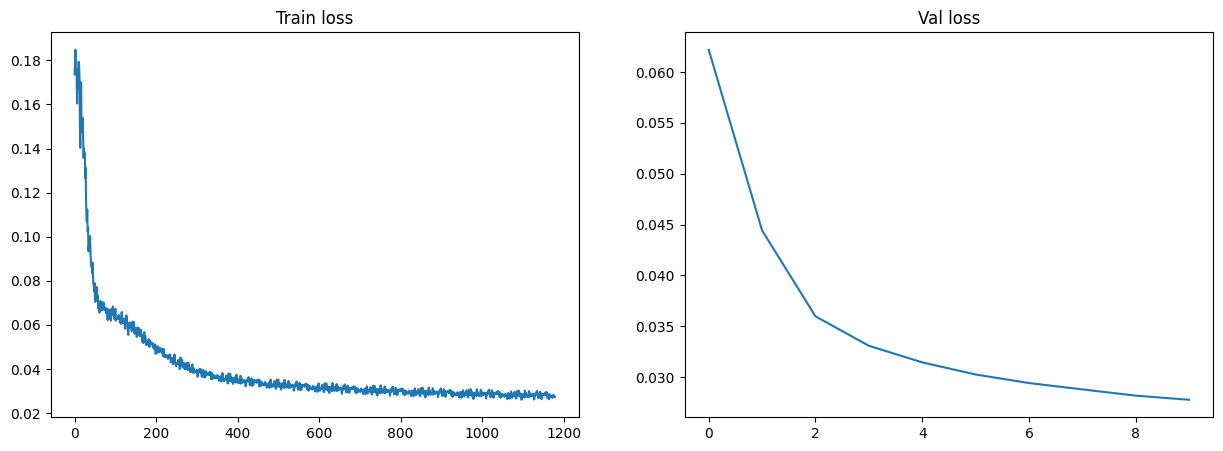

In [8]:
# Plot learning curves
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
axes[0].set_title('Train loss')
axes[0].plot(train_losses)
axes[1].set_title('Val loss')
axes[1].plot(val_losses)


## Model validation

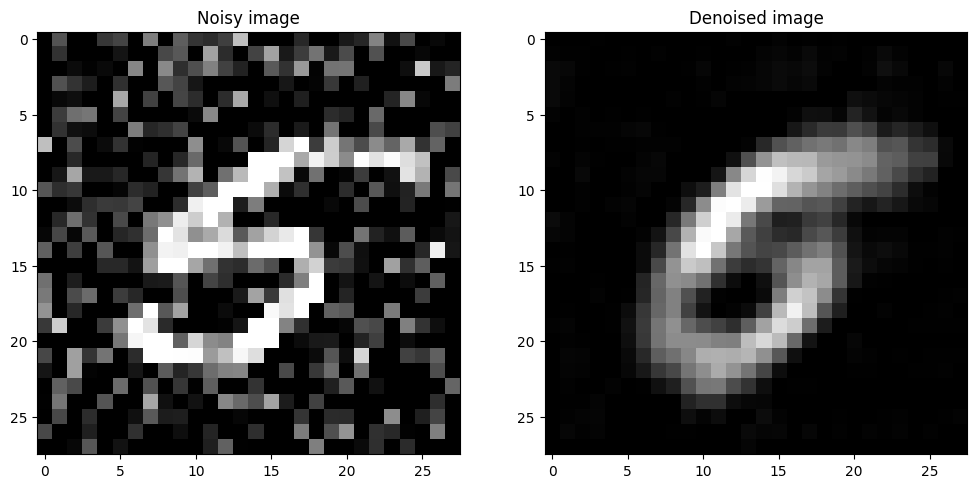

In [9]:
# Get sample
val_img, _ = sample(list(val_dataset), 1)[0]

# Add noise
noisy_val_img = add_noise(val_img)

# Predict denoised image
model.eval()
with torch.no_grad(): output = model(noisy_val_img.to(device)[None, ...])[0, ...]
denoised_val_img = output.clip(0, 1).cpu().numpy()

# Plot sample
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
axes[0].set_title('Noisy image')
axes[0].imshow(noisy_val_img[0], cmap='gray')
axes[1].set_title('Denoised image')
axes[1].imshow(denoised_val_img[0], cmap='gray')